add dice: https://www.kaggle.com/code/yerramvarun/understanding-dice-coefficient

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
import random
import cv2

from pretraining_functions import Unet_encoder, resnet50_encoder, unet_mod, BarlowTwins
from finetuning_functions import DataLoader, training_plots, dice_coefficient


2023-11-17 17:38:47.508066: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-17 17:38:47.546230: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 17:38:47.546257: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 17:38:47.546288: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 17:38:47.554072: I tensorflow/core/platform/cpu_feature_g

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
input_shape = (512, 512, 3)
width = input_shape[0]
batch_size = 4

In [3]:
model_path = os.path.join("..", "..", "..", "media", "FS2","models")

# Data Loading

In [4]:
labeled_data_dir = os.path.join("..", "..", "..", "media", "FS2", "data", "updated_masks")

In [5]:
masked_images = [0 for i in range(150)]
smoke_masks = [0 for i in range(150)] 
cloud_masks =[0 for i in range(150)]
image_nos = []
for subdir, dirs, files in os.walk(labeled_data_dir):
    for file in files:
        file_path = os.path.join(labeled_data_dir, file)
        mask = np.load(os.path.join(labeled_data_dir, file))
        image_no = int(file.split("-")[1])-1
        image_nos.append(image_no)
        if "Smoke" in file_path and not "cloud" in file:
            smoke_masks[image_no] = mask
        if "cloud" in file:
            cloud_masks[image_no] = mask

In [6]:
for i in range(len(smoke_masks)):
    if np.shape(cloud_masks[i]) == ():
        blank_img = np.zeros(smoke_masks[i].shape,dtype=np.uint8)
        cloud_masks[i] = blank_img
    if np.shape(smoke_masks[i]) == ():
        blank_img = np.zeros(cloud_masks[i].shape,dtype=np.uint8)
        smoke_masks[i] = blank_img

In [7]:
(len(smoke_masks), len(cloud_masks))

(150, 150)

In [8]:
def combine_masks(smoke_masks, cloud_masks):
    masks = [0 for i in range(len(smoke_masks))]
    for i in range(len(smoke_masks)):
        smoke = smoke_masks[i]
        smoke = np.where(smoke==0, smoke, 1)
        temp = cloud_masks[i]
        temp = np.where(cloud_masks[i]!=255, cloud_masks[i], 2) #changing color to grey
        temp = np.where(cloud_masks[i]==0, temp, 2)
        full_mask = temp + smoke
        full_mask = np.where(full_mask!=3, full_mask, 1 )
        masks[i] = full_mask
    return masks

In [9]:
masked_images = combine_masks(smoke_masks, cloud_masks)

In [10]:
import re
numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [11]:
originals = []
original_image_dir = os.path.join("..", "..", "..", "media", "FS2", "data", "updated_images")
for subdir, dirs, files in os.walk(original_image_dir):
    for file in sorted(files, key=numericalSort):
        image = Image.open(os.path.join(original_image_dir, file)).convert('RGB')
        np_original = np.asarray(image)
        originals.append(np_original)
originals = originals[:150]
len(originals)

150

In [12]:
random.seed(42)
inds = random.sample([i for i in range(150)], 25)

In [13]:
class DataLoader:
    def __init__(self, masks, originals, target_shape=(256, 256)):
        self.masks = masks
        self.originals = originals
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.target_shape = target_shape
        
    @tf.function
    def parse_images(self, ind):
        mask = cv2.resize(np.expand_dims(self.masks[ind], axis=-1), self.target_shape)
        image = cv2.resize(self.originals[ind], self.target_shape)
        return image, mask
    
    @tf.function
    def data_generator(self, batch_size=4):
        random.seed(0)
        inds = random.sample([i for i in range(len(self.originals))], batch_size)
        inputs = [self.parse_images(ind)[0] for ind in inds]
        targets = [self.parse_images(ind)[1] for ind in inds]
        return inputs, targets

    def data_processor(self):
        inputs = [ cv2.resize(self.originals[ind], self.target_shape) for ind in range(len(self.originals))]
        return inputs


In [14]:
input_size = (512,512)
batch_size = 1
val_batch_size = 1

In [15]:
test_dataset = DataLoader(masked_images, originals, target_shape=input_size)
inputs, targets = test_dataset.data_generator(150)

2023-11-17 17:38:55.694271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14757 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:d5:00.0, compute capability: 7.5


In [16]:
val_input = [inputs[ind] for ind in inds]
val_target = [targets[ind] for ind in inds]
val = tf.data.Dataset.from_tensor_slices((val_input, val_target))

In [17]:
inputs = [inputs[ind] for ind in range(150) if ind not in inds]
targets = [targets[ind] for ind in range(150) if ind not in inds]
train = tf.data.Dataset.from_tensor_slices((inputs, targets))

In [18]:
train_batches = train.batch(batch_size)
val_batches = val.batch(val_batch_size)

# Training Set up

In [19]:
# Callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/smoke_segmentation_256.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=10e-8,
)

In [20]:
# training parameters
batch_size = 1
val_batch_size = 1
epochs = 100
lr = 0.00001

# Unet

In [21]:
optimizer = tf.keras.optimizers.SGD()
input = tf.keras.layers.Input(shape=(input_shape[0], input_shape[1], 3))
encoder = Unet_encoder(input)
barlow_twins = BarlowTwins(encoder)
barlow_twins.compile(optimizer=optimizer)
barlow_twins.encoder.load_weights(os.path.join(model_path, "barlow_twins_UNET"))

2023-11-17 17:34:13.367459: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ../../../media/FS2/models/barlow_twins_UNET: FAILED_PRECONDITION: ../../../media/FS2/models/barlow_twins_UNET; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [22]:
backbone = tf.keras.Model( barlow_twins.encoder.input, barlow_twins.encoder.layers[-2].output)

In [23]:
backbone.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 512, 512, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 512, 512, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 16)      2320      
                                                                 
 batch_normalization_1 (Bat  (None, 512, 512, 16)      64        
 chNormalization)                                          

In [24]:
skip_layers = [backbone.get_layer(index=6).output,
               backbone.get_layer(index=14).output,
               backbone.get_layer(index=22).output,
               backbone.get_layer(index=30).output]

BT_unet = unet_mod(backbone, skip_layers, input, num_filters=16, kernel=3, dropout=0.1, batch_norm=True, train_encoder=True)
BT_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 16)         0         ['batch_normalization[0]

In [25]:
BT_unet.compile(loss="sparse_categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                metrics=["accuracy", 
                        tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_true=True, sparse_y_pred=False)]
                )

In [26]:
history = BT_unet.fit(
    train_batches,
    validation_data=val_batches,
    batch_size=batch_size,
    epochs=epochs, 
    callbacks=[
        early_stop_cb, 
        model_ckpt_cb, 
        reduce_lr_cb
    ])

Epoch 1/100


2023-11-17 17:34:17.339955: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-17 17:34:18.115918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-17 17:34:19.948263: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb5f42ad340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-17 17:34:19.948310: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-17 17:34:19.960116: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-17 17:34:20.106630: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluste

124/125 [============================>.] - ETA: 0s - loss: 1.5251 - accuracy: 0.2054 - mean_io_u: 0.1161

/home/sandrade/miniconda3/envs/odin/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 21s 60ms/step - loss: 1.5268 - accuracy: 0.2045 - mean_io_u: 0.1157 - val_loss: 1.2853 - val_accuracy: 0.2745 - val_mean_io_u: 0.1532 - lr: 1.0000e-05
Epoch 2/100
125/125 [==============================] - 7s 52ms/step - loss: 1.4393 - accuracy: 0.2145 - mean_io_u: 0.1218 - val_loss: 1.3000 - val_accuracy: 0.2817 - val_mean_io_u: 0.1628 - lr: 1.0000e-05
Epoch 3/100
125/125 [==============================] - 7s 54ms/step - loss: 1.3510 - accuracy: 0.2262 - mean_io_u: 0.1292 - val_loss: 1.2417 - val_accuracy: 0.2980 - val_mean_io_u: 0.1753 - lr: 1.0000e-05
Epoch 4/100
125/125 [==============================] - 7s 54ms/step - loss: 1.2771 - accuracy: 0.2418 - mean_io_u: 0.1392 - val_loss: 1.1678 - val_accuracy: 0.3380 - val_mean_io_u: 0.2041 - lr: 1.0000e-05
Epoch 5/100
125/125 [==============================] - 7s 54ms/step - loss: 1.2200 - accuracy: 0.2638 - mean_io_u: 0.1536 - val_loss: 1.1154 - val_accuracy: 0.3812 - val_mean_io_u: 0.2352 - l

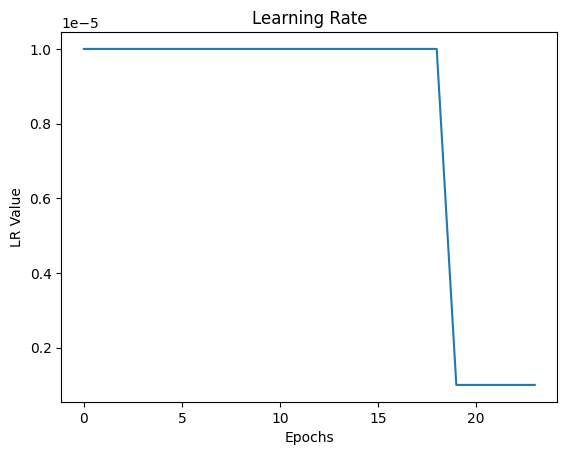

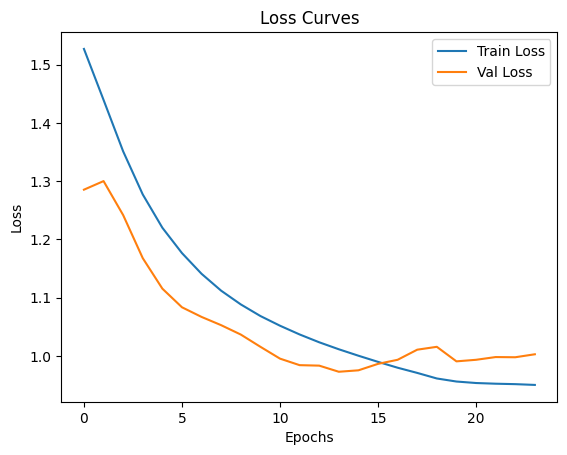

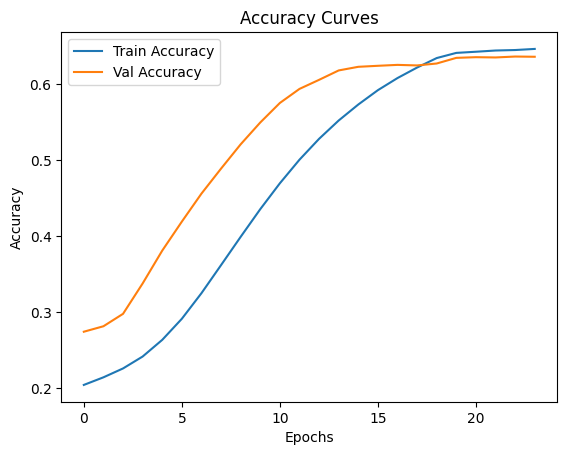

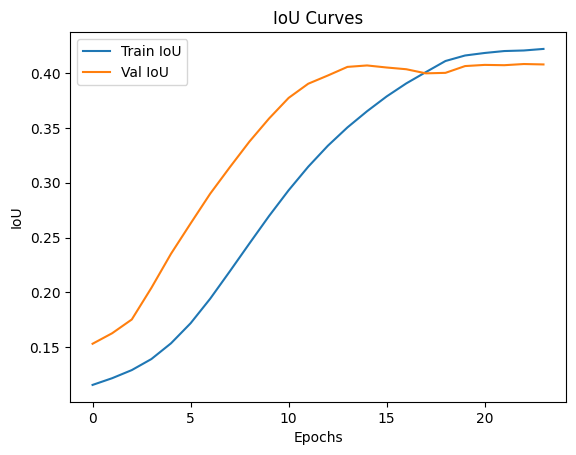

In [27]:
training_plots(history)

In [28]:
# write function to save training/test/validation metrics in a table/csv

# Resnet Unet

In [21]:
optimizer = tf.keras.optimizers.SGD()
input = tf.keras.layers.Input(shape=(input_shape[0], input_shape[1], 3))
encoder = resnet50_encoder(input)
barlow_twins = BarlowTwins(encoder)
barlow_twins.compile(optimizer=optimizer)
barlow_twins.encoder.load_weights(os.path.join(model_path,"barlow_twins_resnet"))
backbone = tf.keras.Model( barlow_twins.encoder.input, barlow_twins.encoder.layers[-2].output)
backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

2023-11-17 17:39:09.916264: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ../../../media/FS2/models/barlow_twins_resnet: FAILED_PRECONDITION: ../../../media/FS2/models/barlow_twins_resnet; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


 conv2_block2_2_relu (Activ  (None, 128, 128, 64)         0         ['conv2_block2_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block2_3_conv (Conv2  (None, 128, 128, 256)        16640     ['conv2_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block2_3_bn (BatchNo  (None, 128, 128, 256)        1024      ['conv2_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block2_add (Add)      (None, 128, 128, 256)        0         ['conv2_block1_out[0][0]',    
          

In [22]:
s1 = backbone.get_layer(index=0).output           ## (512 x 512)
s2 = backbone.get_layer("conv1_relu").output        ## (256 x 256)
s3 = backbone.get_layer("conv2_block3_out").output  ## (128 x 128)
s4 = backbone.get_layer("conv3_block4_out").output  ## (64 x 64)
skip_layers = [s1, s2, s3, s4]

BT_resnet_unet = unet_mod(backbone, skip_layers, input, num_filters=16, kernel=3, dropout=0.1, batch_norm=True, train_encoder=True)
BT_resnet_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [23]:
BT_resnet_unet.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
    metrics=["accuracy", 
             tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_true=True, sparse_y_pred=False)]
            )

In [24]:
history = BT_resnet_unet.fit(
    train_batches,
    validation_data=val_batches,
    batch_size=batch_size,
    epochs=epochs, 
    callbacks=[
        early_stop_cb, 
        model_ckpt_cb, 
        reduce_lr_cb
    ])

Epoch 1/100


2023-11-17 17:39:22.944144: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-17 17:39:24.674653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-17 17:39:26.419611: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efb6c4f61b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-17 17:39:26.419676: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-17 17:39:26.434937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-17 17:39:26.581857: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluste

125/125 [==============================] - ETA: 0s - loss: 1.2333 - accuracy: 0.3197 - mean_io_u: 0.1749

/home/sandrade/miniconda3/envs/odin/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 41s 100ms/step - loss: 1.2333 - accuracy: 0.3197 - mean_io_u: 0.1749 - val_loss: 0.9977 - val_accuracy: 0.5128 - val_mean_io_u: 0.2747 - lr: 1.0000e-05
Epoch 2/100
125/125 [==============================] - 11s 91ms/step - loss: 1.1905 - accuracy: 0.3511 - mean_io_u: 0.1933 - val_loss: 0.9646 - val_accuracy: 0.5279 - val_mean_io_u: 0.3002 - lr: 1.0000e-05
Epoch 3/100
125/125 [==============================] - 11s 90ms/step - loss: 1.1525 - accuracy: 0.3885 - mean_io_u: 0.2156 - val_loss: 0.9374 - val_accuracy: 0.5769 - val_mean_io_u: 0.3381 - lr: 1.0000e-05
Epoch 4/100
125/125 [==============================] - 11s 91ms/step - loss: 1.1180 - accuracy: 0.4271 - mean_io_u: 0.2393 - val_loss: 0.8984 - val_accuracy: 0.6313 - val_mean_io_u: 0.3831 - lr: 1.0000e-05
Epoch 5/100
125/125 [==============================] - 11s 91ms/step - loss: 1.0861 - accuracy: 0.4635 - mean_io_u: 0.2623 - val_loss: 0.8563 - val_accuracy: 0.6786 - val_mean_io_u: 0.424

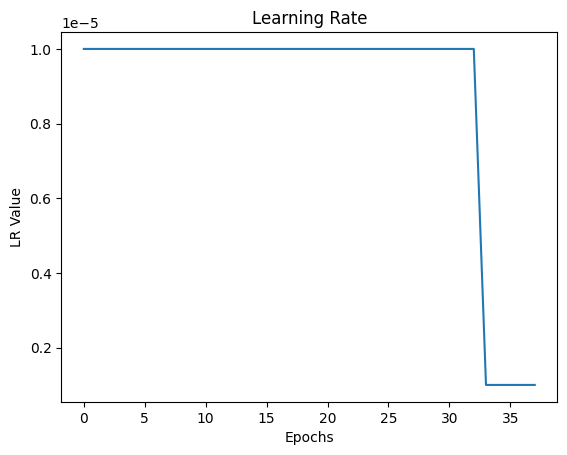

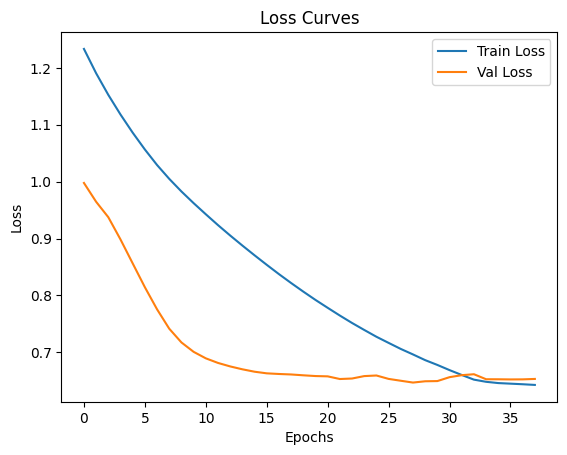

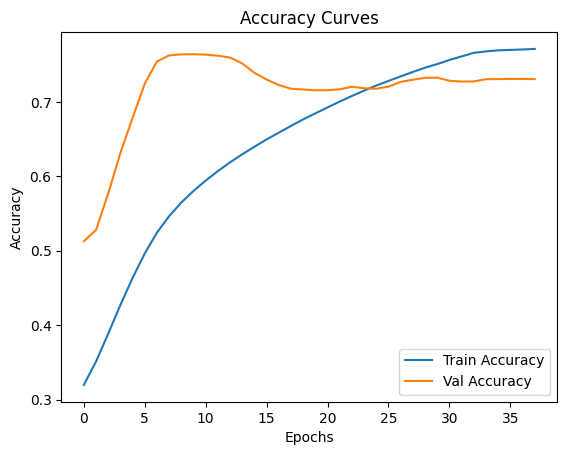

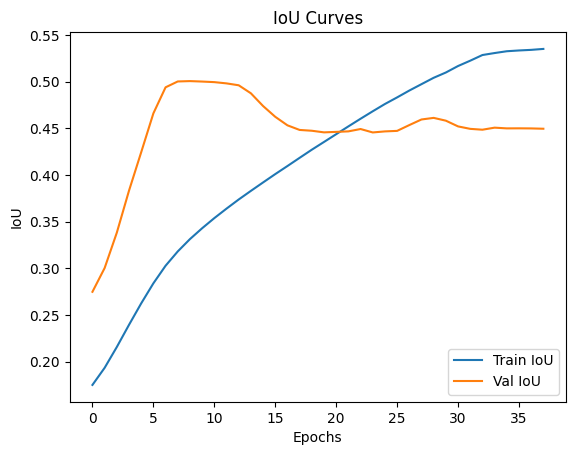

In [25]:
training_plots(history)